# Get Data and Forming Combinations (Done)


In [152]:
import pandas as pd
import yfinance as yf
from vnstock import Vnstock
from typing import List, Dict, Tuple
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
import os
import pandas as pd
from statsmodels.tsa.api import AutoReg
from typing import Dict
from scipy.stats import pearsonr
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
import os
from vnstock import Vnstock  # Assuming this is the correct import for your data source

In [153]:
def get_stock_data(symbols, start_date, end_date, interval='1D'):
    stock_data = pd.DataFrame()  # Initialize empty DataFrame
    for symbol in symbols:
        # Fetch historical data for the symbol
        stock = Vnstock().stock(symbol=symbol, source='VCI')
        historical_data = stock.quote.history(
            start=start_date, 
            end=end_date, 
            interval=interval
        )
        # Set 'time' as the index and keep only the 'Close' column
        close_prices = historical_data[['close', 'time']].set_index('time')
        close_prices = close_prices.rename(columns={'close': symbol})  # Rename column to symbol
        # Concatenate with the main DataFrame
        stock_data = pd.concat([stock_data, close_prices], axis=1).dropna()
    stock_data['Date'] = pd.to_datetime(stock_data.index)
    stock_data = stock_data.set_index('Date').sort_index()
    return stock_data

In [154]:
class DataHandler:
    def __init__(self, futures, stocks, start_date, end_date, file_path, 
                 estimation_window=60, cluster_update_interval=5, 
                 futures_change_threshold=0.05, max_clusters=12):
        self.futures = futures
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date
        self.file_path = file_path
        self.estimation_window = estimation_window
        self.cluster_update_interval = cluster_update_interval
        self.futures_change_threshold = futures_change_threshold
        self.max_clusters = max_clusters
        self.data = self.load_data()
        self.last_clusters = None
        self.last_cluster_day = None
        self.last_futures_price = None
        
    def load_data(self):
        data = get_stock_data([self.futures] + self.stocks, self.start_date, self.end_date, '1D')
        return data.dropna()

    def compute_residuals(self, window_data):
        residuals = pd.DataFrame(index=window_data.index)
        for stock in self.stocks:
            if stock in window_data.columns:
                X = sm.add_constant(window_data[self.futures])
                y = window_data[stock]
                model = sm.OLS(y, X).fit()
                residuals[stock] = model.resid
        return residuals.dropna()

    def cluster_stocks(self, window_data, current_day, futures_current_price):
        if self.last_clusters is not None and self.last_cluster_day is not None:
            days_since_last_cluster = (current_day - self.last_cluster_day).days
            futures_change = abs(futures_current_price - self.last_futures_price) / self.last_futures_price if self.last_futures_price else 0
            if days_since_last_cluster < self.cluster_update_interval and futures_change < self.futures_change_threshold:
                return self.last_clusters
        residuals = self.compute_residuals(window_data)
        if residuals.empty or len(residuals.columns) < 2:
            self.last_clusters = [self.stocks]
        else:
            X = residuals.T
            best_k = 2
            best_score = -1
            for k in range(2, min(self.max_clusters + 1, len(self.stocks))):
                kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
                if kmeans.n_clusters > 1:
                    score = silhouette_score(X, kmeans.labels_)
                    if score > best_score:
                        best_score = score
                        best_k = k
            kmeans = KMeans(n_clusters=best_k, random_state=0).fit(X)
            clusters = {i: [] for i in range(best_k)}
            for stock, label in zip(self.stocks, kmeans.labels_):
                clusters[label].append(stock)
            self.last_clusters = [cluster for cluster in clusters.values() if cluster]
        self.last_cluster_day = current_day
        self.last_futures_price = futures_current_price
        return self.last_clusters

class StatArbStrategy:    
    def __init__(self, data_handler, min_trading_days=30, threshold=0.05,
                 max_stocks=8, confidence_level=1, adf_significance=0.05,
                 correlation_threshold=0.6, dynamic_threshold=True,
                 residual_threshold=0.1):
        self.data_handler = data_handler
        self.futures = data_handler.futures
        self.stocks = data_handler.stocks
        self.estimation_window = data_handler.estimation_window
        self.data = data_handler.data
        self.min_trading_days = min_trading_days
        self.threshold = threshold
        self.max_stocks = max_stocks
        self.confidence_level = confidence_level
        self.confidence_level_joh_final = min(2, confidence_level + 1)
        self.adf_significance = adf_significance
        self.adf_significance_trading = min(0.1, 2 * adf_significance)
        self.correlation_threshold = correlation_threshold
        self.dynamic_threshold = dynamic_threshold
        self.residual_threshold = residual_threshold
        self.active_combinations = []
        self.combination_id = 0
        self.results = []
        self.validation_cache = {}

    def get_pairwise_candidates(self, window_data, stocks_pool):
        candidates = []
        for stock in stocks_pool:
            try:
                result = coint_johansen(window_data[[self.futures, stock]], det_order=1, k_ar_diff=1)
                if result.lr1[0] > result.cvt[0, self.confidence_level]:
                    candidates.append((stock, result.lr1[0]))
            except Exception as e:
                print(f"Pairwise test failed for {stock}: {e}")
        candidates.sort(key=lambda x: x[1], reverse=True)
        return [stock for stock, _ in candidates]

    def build_combination_greedy(self, window_data, candidates):
        if not candidates:
            return []
        selected = [candidates[0]]
        best_trace_stat = coint_johansen(window_data[[self.futures, selected[0]]], det_order=1, k_ar_diff=1).lr1[0]
        for stock in candidates[1:]:
            if len(selected) >= self.max_stocks:
                break
            test_subset = selected + [stock]
            try:
                result = coint_johansen(window_data[[self.futures] + test_subset], det_order=1, k_ar_diff=1)
                if result.lr1[0] <= result.cvt[0, self.confidence_level]:
                    continue
                improvement = (result.lr1[0] - best_trace_stat) / best_trace_stat
                if improvement < 0.05:
                    break
                evec = result.evec[:, 0]
                betas = -evec[1:] / evec[0]
                if not all(beta >= 0 for beta in betas):
                    continue
                selected.append(stock)
                best_trace_stat = result.lr1[0]
            except Exception as e:
                print(f"Combination test failed: {e}")
        return selected

    def validate_combination(self, window_data, selected):
        comb_key = frozenset(selected)
        if comb_key in self.validation_cache:
            return self.validation_cache[comb_key]
        try:
            result = coint_johansen(window_data[[self.futures] + list(selected)], det_order=1, k_ar_diff=1)
            if result.lr1[0] <= result.cvt[0, self.confidence_level_joh_final]:
                self.validation_cache[comb_key] = (None, np.inf)
                return None, np.inf
            evec = result.evec[:, 0]
            betas = -evec[1:] / evec[0]
            if not all(beta >= 0 for beta in betas):
                self.validation_cache[comb_key] = (None, np.inf)
                return None, np.inf
            
            synthetic_portfolio = sum(window_data[s] * b for s, b in zip(selected, betas))
            residuals = window_data[self.futures] - synthetic_portfolio
            intercept = -residuals.mean()
            adf_pvalue = adfuller(residuals)[1]
            if adf_pvalue >= self.adf_significance:
                self.validation_cache[comb_key] = (None, adf_pvalue)
                return None, adf_pvalue
            futures_avg = window_data[self.futures].mean()
            if np.percentile(np.abs(residuals), 95) > self.residual_threshold * futures_avg:
                self.validation_cache[comb_key] = (None, adf_pvalue)
                return None, adf_pvalue
            selected_betas = {s: b for s, b in zip(selected, betas) if abs(b) > self.threshold}
            combination_params = {'intercept': intercept, 'betas': selected_betas}
            self.validation_cache[comb_key] = (combination_params, adf_pvalue)
            return combination_params, adf_pvalue
        except Exception as e:
            print(f"Validation failed for {selected}: {e}")
            self.validation_cache[comb_key] = (None, np.inf)
            return None, np.inf

    def is_similar(self, new_residuals, existing_residuals):
        if len(new_residuals) != len(existing_residuals):
            return False
        corr, _ = pearsonr(new_residuals, existing_residuals)
        return corr > self.correlation_threshold

    def adjust_correlation_threshold(self):
        if self.dynamic_threshold:
            if len(self.active_combinations) < 10:
                self.correlation_threshold = min(0.8, self.correlation_threshold + 0.05)
            else:
                self.correlation_threshold = max(0.5, self.correlation_threshold - 0.05)

    def run_strategy(self):
        for day in range(self.estimation_window, len(self.data)):
            estimation_data = self.data.iloc[day - self.estimation_window:day]
            current_day = self.data.index[day]
            futures_current_price = self.data.iloc[day][self.futures]
            self.adjust_correlation_threshold()
            clusters = self.data_handler.cluster_stocks(estimation_data, current_day, futures_current_price)

            for cluster in clusters:
                candidates = self.get_pairwise_candidates(estimation_data, cluster)
                selected = self.build_combination_greedy(estimation_data, candidates)
                if selected:
                    params, new_adf_pvalue = self.validate_combination(estimation_data, selected)
                    if params:
                        self.add_combination_if_not_similar(params, new_adf_pvalue, estimation_data, current_day)

            top_candidates = []
            for cluster in clusters:
                cluster_candidates = self.get_pairwise_candidates(estimation_data, cluster)[:3]
                top_candidates.extend(cluster_candidates)
            top_candidates = list(set(top_candidates))

            if top_candidates:
                cross_selected = self.build_combination_greedy(estimation_data, top_candidates)
                if cross_selected:
                    cross_params, cross_adf_pvalue = self.validate_combination(estimation_data, cross_selected)
                    if cross_params:
                        self.add_combination_if_not_similar(cross_params, cross_adf_pvalue, estimation_data, current_day)

            all_candidates = self.get_pairwise_candidates(estimation_data, self.stocks)
            cross_selected = self.build_combination_greedy(estimation_data, all_candidates)
            if cross_selected:
                cross_params, cross_adf_pvalue = self.validate_combination(estimation_data, cross_selected)
                if cross_params:
                    self.add_combination_if_not_similar(cross_params, cross_adf_pvalue, estimation_data, current_day)

            for comb in self.active_combinations[:]:
                if day < comb['start_day']:
                    continue
                comb['trading_days'] += 1
                current_prices = self.data.iloc[day]
                synthetic_portfolio = sum(current_prices[s] * b for s, b in comb['params']['betas'].items())
                residual = current_prices[self.futures] - (comb['params']['intercept'] + synthetic_portfolio)
                comb['all_residuals'].append(residual)
                if comb['trading_days'] >= self.min_trading_days:
                    recent_residuals = pd.Series(comb['all_residuals'][-self.estimation_window:])
                    if adfuller(recent_residuals)[1] >= self.adf_significance_trading:
                        self.active_combinations.remove(comb)
                        continue
                row = {
                    'Date': current_day,
                    'Combination_ID': comb['id'],
                    'Residual': residual,
                    'Total_Combinations': len(self.active_combinations),
                    'Num_Stocks': len(comb['params']['betas']),
                    'Is_Estimation': False,
                    'Intercept': comb['params']['intercept'],
                    **{f'Beta_{s}': b for s, b in comb['params']['betas'].items()}
                }
                self.results.append(row)

    def add_combination_if_not_similar(self, params, new_adf_pvalue, estimation_data, current_day):
        synthetic_portfolio = sum(estimation_data[s] * b for s, b in params['betas'].items())
        residuals = estimation_data[self.futures] - (params['intercept'] + synthetic_portfolio)
        similar_found = False
        to_remove = []
        for comb in self.active_combinations:
            existing_residuals = pd.Series(comb['all_residuals'][-self.estimation_window:])
            if self.is_similar(residuals, existing_residuals):
                if comb['trading_days'] >= self.min_trading_days:
                    existing_adf_pvalue = adfuller(existing_residuals)[1]
                    if new_adf_pvalue < 0.5 * existing_adf_pvalue:
                        to_remove.append(comb)
                else:
                    similar_found = True
        for comb in to_remove:
            self.active_combinations.remove(comb)
        if not similar_found:
            self.combination_id += 1
            self.active_combinations.append({
                'id': self.combination_id,
                'params': params,
                'start_day': self.data.index.get_loc(current_day),
                'all_residuals': residuals.tolist(),
                'trading_days': 0
            })
            for i, res in enumerate(residuals):
                row = {
                    'Date': estimation_data.index[i],
                    'Combination_ID': self.combination_id,
                    'Residual': res,
                    'Total_Combinations': len(self.active_combinations),
                    'Num_Stocks': len(params['betas']),
                    'Is_Estimation': True,
                    'Intercept': params['intercept'],
                    **{f'Beta_{s}': b for s, b in params['betas'].items()}
                }
                self.results.append(row)
            print(f"\n=== New Combination {self.combination_id} at {current_day.date()} ===")
            print(f"VN30F1M = {params['intercept']:.3f} + " + " + ".join([f"{b:.3f}*{s}" for s, b in params['betas'].items()]))

    def get_results(self):
        results_df = pd.DataFrame(self.results)
        # Add all stocks to results_df with 0 betas for non-combination stocks
        for stock in self.stocks:
            beta_col = f'Beta_{stock}'
            if beta_col not in results_df.columns:
                results_df[beta_col] = 0.0
        results_df = results_df.sort_values(by=['Combination_ID', 'Date'])
        stock_price = self.data
        return results_df, stock_price



In [155]:
futures = 'VN30F1M'
stocks = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'LPB', 'MBB', 'MSN', 'MWG',
          'PLX', 'SAB', 'SHB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VRE',
          'VPB', 'FUEVFVND', 'FUESSVFL', 'E1VFVN30', 'FUEVN100']
start_date = '2024-01-01'
end_date = '2024-12-31'
file_path = 'data\\stock_data.csv'
data_handler = DataHandler(
    futures=futures,
    stocks=stocks, 
    start_date='2024-01-01',
    end_date='2025-01-01',
    file_path='stock_data.csv'
)

strategy = StatArbStrategy(data_handler)
strategy.run_strategy()
results_df_1,stock_price = strategy.get_results()

2025-03-20 20:10:54 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:55 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:56 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:56 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:57 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:57 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:58 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2025-03-20 20:10:59 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS



=== New Combination 1 at 2024-04-03 ===
VN30F1M = 15.301 + 47.852*E1VFVN30 + 0.734*FUEVFVND + 0.930*ACB + 1.151*VJC + 1.465*VIB + 0.665*VCB

=== New Combination 2 at 2024-04-03 ===
VN30F1M = 105.392 + 41.458*E1VFVN30 + 1.776*FUEVFVND + 3.007*ACB + 1.700*VJC + 2.054*VIB + 1.531*VCB + 1.021*GVR

=== New Combination 3 at 2024-04-11 ===
VN30F1M = 25.967 + 8.528*E1VFVN30 + 40.259*FUEVN100 + 13.644*FUESSVFL + 1.669*MBB + 6.633*TPB

=== New Combination 4 at 2024-04-12 ===
VN30F1M = 50.015 + 25.961*E1VFVN30 + 25.804*FUEVN100 + 14.477*FUESSVFL + 0.298*STB

=== New Combination 5 at 2024-04-17 ===
VN30F1M = -92.187 + 5.952*STB + 45.117*E1VFVN30

=== New Combination 6 at 2024-05-07 ===
VN30F1M = 8.320 + 1.557*STB + 55.376*E1VFVN30 + 0.236*BCM

=== New Combination 7 at 2024-06-12 ===
VN30F1M = 3.054 + 51.318*E1VFVN30 + 3.116*VIC

=== New Combination 8 at 2024-06-18 ===
VN30F1M = 44.750 + 59.481*E1VFVN30 + 0.150*VPB

=== New Combination 9 at 2024-07-09 ===
VN30F1M = 96.132 + 29.897*SHB + 38.696*E1V

In [44]:
results_df_1.to_csv('draft\\results.csv', index=False)

## Generating Trading Signal ( Still Debugging Position_df and trading_signal)

new

In [ ]:
# # Now debugging the lockup period of 2 days --> cannot be in used, check the below code
# class SignalGenerator:
#     def __init__(self, residuals: pd.DataFrame, ou_window: int = 60, fallback_days: int = 5):
#         self.residuals = residuals
#         self.ou_window = ou_window
#         self.fallback_days = fallback_days
#         self.ou_params = None
#         self.last_valid_params = {col: None for col in residuals.columns}
#         self.ou_cache = {}

#     def fit_ou_process(self, series: pd.Series, date: pd.Timestamp) -> Dict[str, float]:
#         cache_key = (series.name, date)
#         if cache_key in self.ou_cache:
#             return self.ou_cache[cache_key]
#         if len(series) < self.ou_window:
#             return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
#         series_window = series[-self.ou_window:].dropna().to_numpy()
#         if len(series_window) < self.ou_window:
#             return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
#         try:
#             model = AutoReg(series_window, lags=1).fit()
#             a, b = model.params
#             p_value_b = model.pvalues[1]
#             if p_value_b >= 0.10 or b <= 0 or b >= 1:
#                 return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
#             kappa = -np.log(b) * np.sqrt(252)
#             m = a / (1 - b)
#             sigma = np.sqrt(model.sigma2 * 2 * kappa / (1 - b**2))
#             latest = series.iloc[-1]
#             sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
#             s_score = (latest - m) / sigma_eq if sigma_eq != 0 else 0
#             params = {'kappa': kappa, 'm': m, 'sigma': sigma, 's_score': s_score}
#             self.ou_cache[cache_key] = params
#             return params
#         except (ValueError, np.linalg.LinAlgError):
#             return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}

#     def apply_ou_fitting(self):
#         columns = pd.MultiIndex.from_product([self.residuals.columns, ['kappa', 'm', 'sigma', 's_score']])
#         self.ou_params = pd.DataFrame(index=self.residuals.index, columns=columns)
#         for t in range(self.ou_window, len(self.residuals)):
#             date = self.residuals.index[t]
#             for stock in self.residuals.columns:
#                 series = self.residuals[stock].iloc[:t + 1]
#                 params = self.fit_ou_process(series, date)
#                 if not np.isnan(params['kappa']):
#                     self.last_valid_params[stock] = {'params': params, 'date': date}
#                 elif self.last_valid_params[stock] and (date - self.last_valid_params[stock]['date']).days <= self.fallback_days:
#                     last_params = self.last_valid_params[stock]['params']
#                     latest = series.iloc[-1]
#                     m, kappa, sigma = last_params['m'], last_params['kappa'], last_params['sigma']
#                     sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
#                     params['s_score'] = (latest - m) / sigma_eq if sigma_eq != 0 else 0
#                 for param, value in params.items():
#                     self.ou_params.loc[date, (stock, param)] = value

# def get_allocation_tier(s_score: float, prev_allocation: float, prev_s_score: float, is_decreasing_trend: bool) -> float:
#     if s_score > 2.0 or s_score < -1.5:
#         return 0.0
#     elif s_score > 1.5 and s_score > prev_s_score:
#         return 1.25
#     elif s_score > 1.25 and s_score > prev_s_score:
#         return 1.0
#     elif s_score > 1.0:
#         return 0.75
#     elif prev_allocation > 0:
#         if s_score < 1.0 and s_score < prev_s_score:
#             return max(0.0, prev_allocation - 0.1)
#         elif s_score > prev_s_score and is_decreasing_trend:
#             return max(0.0, prev_allocation - 0.2)
#         else:
#             return prev_allocation
#     return 0.0

# def generate_signals(residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
#     signal_gen = SignalGenerator(residuals_pivot, ou_window=ou_window)
#     signal_gen.apply_ou_fitting()
#     return signal_gen.ou_params

# def compute_allocations(ou_params: pd.DataFrame, residuals_pivot: pd.DataFrame, lockup_days: int = 0, ou_window: int =60,) -> Tuple[pd.DataFrame, Dict]:
#     allocation_percentages = pd.DataFrame(index=ou_params.index, columns=residuals_pivot.columns, dtype=float).fillna(0.0)
#     lockup_tracker = {comb_id: None for comb_id in residuals_pivot.columns}
#     trend_tracker = {comb_id: False for comb_id in residuals_pivot.columns}

#     for comb_id in allocation_percentages.columns:
#         s_scores = ou_params[(comb_id, 's_score')]
#         prev_allocation = 0.0
#         prev_s_score = np.nan
#         for i, date in enumerate(s_scores.index):
#             if i < ou_window:
#                 allocation = 0.0
#             else:
#                 s_score = s_scores[date]
#                 if pd.isna(s_score) or pd.isna(residuals_pivot.loc[date, comb_id]):
#                     allocation = 0.0
#                 else:
#                     is_decreasing = s_score < prev_s_score if not pd.isna(prev_s_score) else False
#                     trend_tracker[comb_id] = is_decreasing
#                     intended_allocation = get_allocation_tier(s_score, prev_allocation, prev_s_score, trend_tracker[comb_id])
#                     if intended_allocation > 0:
#                         if prev_allocation == 0:
#                             lockup_tracker[comb_id] = date
#                         allocation = intended_allocation
#                     elif intended_allocation == 0 and prev_allocation > 0:
#                         if lockup_days > 0 and lockup_tracker[comb_id] and (date - lockup_tracker[comb_id]).days < lockup_days:
#                             allocation = prev_allocation
#                         else:
#                             allocation = 0.0
#                             lockup_tracker[comb_id] = None
#                     else:
#                         allocation = 0.0
#                     prev_s_score = s_score if not pd.isna(s_score) else prev_s_score
#             allocation_percentages.loc[date, comb_id] = allocation
#             prev_allocation = allocation
#     return allocation_percentages, lockup_tracker

# def calculate_positions(allocation_percentages: pd.DataFrame, results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list, lockup_tracker: Dict) -> pd.DataFrame:
#     dates = pd.date_range(start=results_df['Date'].min(), end=results_df['Date'].max(), freq='D')
#     positions_df = pd.DataFrame(index=dates, columns=[f'Position_{asset}' for asset in ['VN30F1M'] + stocks] + ['Num_Active_Combinations', 'Active_Combination_IDs'], dtype=float)
#     positions_df['Active_Combination_IDs'] = positions_df['Active_Combination_IDs'].astype(object)
#     positions_df = positions_df.fillna(0.0)

#     for date in dates:
#         if date not in allocation_percentages.index:
#             continue
#         active_combs = allocation_percentages.loc[date][allocation_percentages.loc[date] > 0]
#         num_active = len(active_combs)
#         active_ids = list(active_combs.index)
#         positions_df.loc[date, 'Num_Active_Combinations'] = num_active
#         positions_df.loc[date, 'Active_Combination_IDs'] = str(active_ids)

#         if num_active == 0:
#             total_short = 0.0
#         else:
#             base_allocation = min(0.6 + 0.1 * (num_active - 1), 1.0)
#             intended_allocations = active_combs * base_allocation
#             total_intended = intended_allocations.sum()
#             scale_factor = 1.0 / total_intended if total_intended > 1.0 else 1.0
#             scaled_allocations = intended_allocations * scale_factor
#             total_short = scaled_allocations.sum()
#         positions_df.loc[date, 'Position_VN30F1M'] = -total_short

#         for comb_id in active_combs.index:
#             allocation = scaled_allocations[comb_id]
#             comb_row = results_df[(results_df['Date'] == date) & (results_df['Combination_ID'] == comb_id)]
#             if comb_row.empty:
#                 continue
#             entry_date = lockup_tracker[comb_id]
#             if entry_date not in stock_price.index:
#                 continue

#             # Identify all stocks in the combination with positive betas
#             comb_stocks = [s for s in stocks if f'Beta_{s}' in comb_row.columns and comb_row[f'Beta_{s}'].values[0] >= 0]
#             sum_beta_price = 0.0
#             valid_comb_stocks = []
#             for s in comb_stocks:
#                 beta = comb_row[f'Beta_{s}'].values[0]
#                 price = stock_price.loc[entry_date, s] if s in stock_price.columns and not pd.isna(stock_price.loc[entry_date, s]) else np.nan
#                 if not pd.isna(price):
#                     sum_beta_price += beta * price
#                     valid_comb_stocks.append(s)

#             if sum_beta_price >= 0:
#                 for stock in valid_comb_stocks:
#                     beta = comb_row[f'Beta_{stock}'].values[0]
#                     entry_price = stock_price.loc[entry_date, stock]
#                     stock_proportion = (beta * entry_price) / sum_beta_price
#                     stock_position = allocation * stock_proportion
#                     positions_df.loc[date, f'Position_{stock}'] += stock_position

#     return positions_df

# def process_results_df(results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list, ou_window: int = 60, lockup_days: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
#     results_df = results_df.sort_values('Date')
#     residuals_pivot = results_df.pivot(index='Date', columns='Combination_ID', values='Residual')

#     # Generate signals
#     ou_params = generate_signals(residuals_pivot, ou_window=ou_window)

#     # Compute allocations and update lockup tracker
#     allocation_percentages, lockup_tracker = compute_allocations(ou_params, residuals_pivot, lockup_days=lockup_days)

#     # Calculate positions
#     positions_df = calculate_positions(allocation_percentages, results_df, stock_price, stocks, lockup_tracker)

#     # Add s-scores and allocations to results_df
#     results_df['s_score'] = results_df.apply(
#         lambda row: ou_params.loc[row['Date'], (row['Combination_ID'], 's_score')]
#         if row['Date'] in ou_params.index else np.nan, axis=1
#     )
#     results_df['Allocation'] = results_df.apply(
#         lambda row: allocation_percentages.loc[row['Date'], row['Combination_ID']]
#         if row['Date'] in allocation_percentages.index else 0.0, axis=1
#     )

#     # Add absolute values to positions_df
#     for date in positions_df.index:
#         if date in stock_price.index and not pd.isna(stock_price.loc[date, 'VN30F1M']):
#             positions_df.loc[date, 'Abs_VN30F1M'] = abs(positions_df.loc[date, 'Position_VN30F1M']) * stock_price.loc[date, 'VN30F1M']
#             total_abs_stocks = 0.0
#             for stock in stocks:
#                 if not pd.isna(stock_price.loc[date, stock]):
#                     abs_stock = positions_df.loc[date, f'Position_{stock}'] * stock_price.loc[date, stock]
#                     positions_df.loc[date, f'Abs_{stock}'] = abs_stock
#                     total_abs_stocks += abs_stock
#                 else:
#                     positions_df.loc[date, f'Abs_{stock}'] = np.nan
#             positions_df.loc[date, 'Total_Abs_Stocks'] = total_abs_stocks
#         else:
#             positions_df.loc[date, 'Abs_VN30F1M'] = np.nan
#             positions_df.loc[date, 'Total_Abs_Stocks'] = np.nan
#             for stock in stocks:
#                 positions_df.loc[date, f'Abs_{stock}'] = np.nan

#     # Round positions
#     for col in positions_df.columns:
#         if col.startswith('Position_') or col.startswith('Abs_') or col == 'Total_Abs_Stocks':
#             positions_df[col] = positions_df[col].apply(lambda x: round(x, 4) if pd.notna(x) and abs(x) > 1e-10 else 0.0)

#     # Generate trading log
#     trading_log = pd.DataFrame(index=positions_df.index)
#     pos_vn30 = positions_df['Position_VN30F1M']
#     delta_vn30 = pos_vn30.diff().fillna(0.0)
#     trading_log['Delta_VN30F1M'] = delta_vn30.apply(lambda x: round(x, 4) if abs(x) > 1e-10 else 0.0)
#     trading_log['Action_VN30F1M'] = np.where(
#         (trading_log['Delta_VN30F1M'] > 0) & (pos_vn30.shift(1).fillna(0.0) < 0), 'buy to cover',
#         np.where(trading_log['Delta_VN30F1M'] < 0, 'sell short', 'hold')
#     )

#     for stock in stocks:
#         pos_col = f'Position_{stock}'
#         delta_col = f'Delta_{stock}'
#         action_col = f'Action_{stock}'
#         pos_stock = positions_df[pos_col]
#         delta_stock = pos_stock.diff().fillna(0.0)
#         trading_log[delta_col] = delta_stock.apply(lambda x: round(x, 4) if abs(x) > 1e-10 else 0.0)
#         trading_log[action_col] = np.where(trading_log[delta_col] > 0, 'buy',
#                                           np.where(trading_log[delta_col] < 0, 'sell', 'hold'))

#     trading_log['Total_Position'] = positions_df[[col for col in positions_df.columns if col.startswith('Position_')]].sum(axis=1).apply(lambda x: round(x, 4))
#     trading_log['Num_Active_Combinations'] = positions_df['Num_Active_Combinations']
#     trading_log['Active_Combination_IDs'] = positions_df['Active_Combination_IDs']

#     # Reorder columns
#     positions_df = positions_df[['Num_Active_Combinations', 'Active_Combination_IDs', 'Abs_VN30F1M', 'Total_Abs_Stocks'] + [col for col in positions_df.columns if col not in ['Num_Active_Combinations', 'Active_Combination_IDs', 'Abs_VN30F1M', 'Total_Abs_Stocks']]]
#     trading_log = trading_log[['Num_Active_Combinations', 'Active_Combination_IDs'] + [col for col in trading_log.columns if col not in ['Num_Active_Combinations', 'Active_Combination_IDs']]]

#     # Set Date as index
#     positions_df.reset_index(inplace=True)
#     positions_df.rename(columns={'index': 'Date'}, inplace=True)
#     positions_df.set_index('Date', inplace=True)
#     trading_log.reset_index(inplace=True)
#     trading_log.rename(columns={'index': 'Date'}, inplace=True)
#     trading_log.set_index('Date', inplace=True)

#     results_df.sort_values(by=['Combination_ID', 'Date'], inplace=True)
#     positions_df.sort_index(inplace=True)
#     trading_log.sort_index(inplace=True)

#     return results_df, positions_df, trading_log

# # Example usage:
# # results_df, positions_df, trading_log = process_results_df(results_df, stock_price, stocks)

In [156]:
class SignalGenerator:
    def __init__(self, residuals: pd.DataFrame, ou_window: int = 60, fallback_days: int = 5):
        self.residuals = residuals
        self.ou_window = ou_window
        self.fallback_days = fallback_days
        self.ou_params = None
        self.last_valid_params = {col: None for col in residuals.columns}
        self.ou_cache = {}

    def fit_ou_process(self, series: pd.Series, date: pd.Timestamp) -> Dict[str, float]:
        cache_key = (series.name, date)
        if cache_key in self.ou_cache:
            return self.ou_cache[cache_key]
        if len(series) < self.ou_window:
            return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
        series_window = series[-self.ou_window:].dropna().to_numpy()
        if len(series_window) < self.ou_window:
            return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
        try:
            model = AutoReg(series_window, lags=1).fit()
            a, b = model.params
            p_value_b = model.pvalues[1]
            if p_value_b >= 0.10 or b <= 0 or b >= 1:
                return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}
            kappa = -np.log(b) * np.sqrt(252)
            m = a / (1 - b)
            sigma = np.sqrt(model.sigma2 * 2 * kappa / (1 - b**2))
            latest = series.iloc[-1]
            sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
            s_score = (latest - m) / sigma_eq if sigma_eq != 0 else 0
            params = {'kappa': kappa, 'm': m, 'sigma': sigma, 's_score': s_score}
            self.ou_cache[cache_key] = params
            return params
        except (ValueError, np.linalg.LinAlgError):
            return {'kappa': np.nan, 'm': np.nan, 'sigma': np.nan, 's_score': np.nan}

    def apply_ou_fitting(self):
        columns = pd.MultiIndex.from_product([self.residuals.columns, ['kappa', 'm', 'sigma', 's_score']])
        self.ou_params = pd.DataFrame(index=self.residuals.index, columns=columns)
        for t in range(self.ou_window, len(self.residuals)):
            date = self.residuals.index[t]
            for stock in self.residuals.columns:
                series = self.residuals[stock].iloc[:t + 1]
                params = self.fit_ou_process(series, date)
                if not np.isnan(params['kappa']):
                    self.last_valid_params[stock] = {'params': params, 'date': date}
                elif self.last_valid_params[stock] and (date - self.last_valid_params[stock]['date']).days <= self.fallback_days:
                    last_params = self.last_valid_params[stock]['params']
                    latest = series.iloc[-1]
                    m, kappa, sigma = last_params['m'], last_params['kappa'], last_params['sigma']
                    sigma_eq = sigma / np.sqrt(2 * kappa) if kappa > 0 else np.inf
                    params['s_score'] = (latest - m) / sigma_eq if sigma_eq != 0 else 0
                for param, value in params.items():
                    self.ou_params.loc[date, (stock, param)] = value

def get_allocation_tier(s_score: float, prev_allocation: float, prev_s_score: float, is_decreasing_trend: bool) -> float:
    if s_score > 2.0 or s_score < -1.5:
        return 0.0
    elif s_score > 1.5 and s_score > prev_s_score:
        return 1.25
    elif s_score > 1.25 and s_score > prev_s_score:
        return 1.0
    elif s_score > 1.0:
        return 0.75
    elif prev_allocation > 0:
        if s_score < 1.0 and s_score < prev_s_score:
            return max(0.0, prev_allocation - 0.1)
        elif s_score > prev_s_score and is_decreasing_trend:
            return max(0.0, prev_allocation - 0.2)
        else:
            return prev_allocation
    return 0.0

def generate_signals(residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
    signal_gen = SignalGenerator(residuals_pivot, ou_window=ou_window)
    signal_gen.apply_ou_fitting()
    return signal_gen.ou_params

def compute_allocations(ou_params: pd.DataFrame, residuals_pivot: pd.DataFrame, ou_window: int = 60) -> pd.DataFrame:
    allocation_percentages = pd.DataFrame(index=ou_params.index, columns=residuals_pivot.columns, dtype=float).fillna(0.0)
    trend_tracker = {comb_id: False for comb_id in residuals_pivot.columns}

    for comb_id in allocation_percentages.columns:
        s_scores = ou_params[(comb_id, 's_score')]
        prev_allocation = 0.0
        prev_s_score = np.nan
        for i, date in enumerate(s_scores.index):
            if i < ou_window:
                allocation = 0.0
            else:
                s_score = s_scores[date]
                if pd.isna(s_score) or pd.isna(residuals_pivot.loc[date, comb_id]):
                    allocation = 0.0
                else:
                    is_decreasing = s_score < prev_s_score if not pd.isna(prev_s_score) else False
                    trend_tracker[comb_id] = is_decreasing
                    allocation = get_allocation_tier(s_score, prev_allocation, prev_s_score, trend_tracker[comb_id])
                    prev_s_score = s_score if not pd.isna(s_score) else prev_s_score
            allocation_percentages.loc[date, comb_id] = allocation
            prev_allocation = allocation
    return allocation_percentages

def calculate_positions(allocation_percentages: pd.DataFrame, results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list) -> pd.DataFrame:
    dates = pd.date_range(start=results_df['Date'].min(), end=results_df['Date'].max(), freq='D')
    positions_df = pd.DataFrame(index=dates, columns=[f'Position_{asset}' for asset in ['VN30F1M'] + stocks] + ['Num_Active_Combinations', 'Active_Combination_IDs'], dtype=float)
    positions_df['Active_Combination_IDs'] = positions_df['Active_Combination_IDs'].astype(object)
    positions_df = positions_df.fillna(0.0)

    for date in dates:
        if date not in allocation_percentages.index:
            continue
        active_combs = allocation_percentages.loc[date][allocation_percentages.loc[date] > 0]
        num_active = len(active_combs)
        active_ids = list(active_combs.index)
        positions_df.loc[date, 'Num_Active_Combinations'] = num_active
        positions_df.loc[date, 'Active_Combination_IDs'] = str(active_ids)

        if num_active == 0:
            total_short = 0.0
        else:
            base_allocation = min(0.6 + 0.1 * (num_active - 1), 1.0)
            intended_allocations = active_combs * base_allocation
            total_intended = intended_allocations.sum()
            scale_factor = 1.0 / total_intended if total_intended > 1.0 else 1.0
            scaled_allocations = intended_allocations * scale_factor
            total_short = scaled_allocations.sum()
        positions_df.loc[date, 'Position_VN30F1M'] = -total_short

        for comb_id in active_combs.index:
            allocation = scaled_allocations[comb_id]
            comb_row = results_df[(results_df['Date'] == date) & (results_df['Combination_ID'] == comb_id)]
            if comb_row.empty:
                continue
            if date not in stock_price.index:
                continue

            # Identify all stocks in the combination with non-negative betas
            comb_stocks = [s for s in stocks if f'Beta_{s}' in comb_row.columns and comb_row[f'Beta_{s}'].values[0] >= 0]
            sum_beta_price = 0.0
            valid_comb_stocks = []
            for s in comb_stocks:
                beta = comb_row[f'Beta_{s}'].values[0]
                price = stock_price.loc[date, s] if s in stock_price.columns and not pd.isna(stock_price.loc[date, s]) else np.nan
                if not pd.isna(price):
                    sum_beta_price += beta * price
                    valid_comb_stocks.append(s)

            if sum_beta_price > 0:  # Ensure denominator is positive to avoid division issues
                for stock in valid_comb_stocks:
                    beta = comb_row[f'Beta_{stock}'].values[0]
                    current_price = stock_price.loc[date, stock]
                    stock_proportion = (beta * current_price) / sum_beta_price
                    stock_position = allocation * stock_proportion
                    positions_df.loc[date, f'Position_{stock}'] += stock_position

    return positions_df

def process_results_df(results_df: pd.DataFrame, stock_price: pd.DataFrame, stocks: list, ou_window: int = 60) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    results_df = results_df.sort_values('Date')
    residuals_pivot = results_df.pivot(index='Date', columns='Combination_ID', values='Residual')

    # Generate signals
    ou_params = generate_signals(residuals_pivot, ou_window=ou_window)

    # Compute allocations
    allocation_percentages = compute_allocations(ou_params, residuals_pivot, ou_window=ou_window)

    # Calculate positions
    positions_df = calculate_positions(allocation_percentages, results_df, stock_price, stocks)

    # Add s-scores and allocations to results_df
    results_df['s_score'] = results_df.apply(
        lambda row: ou_params.loc[row['Date'], (row['Combination_ID'], 's_score')]
        if row['Date'] in ou_params.index else np.nan, axis=1
    )
    results_df['Allocation'] = results_df.apply(
        lambda row: allocation_percentages.loc[row['Date'], row['Combination_ID']]
        if row['Date'] in allocation_percentages.index else 0.0, axis=1
    )

    # Add absolute values to positions_df
    for date in positions_df.index:
        if date in stock_price.index and not pd.isna(stock_price.loc[date, 'VN30F1M']):
            positions_df.loc[date, 'Abs_VN30F1M'] = abs(positions_df.loc[date, 'Position_VN30F1M']) * stock_price.loc[date, 'VN30F1M']
            total_abs_stocks = 0.0
            for stock in stocks:
                if not pd.isna(stock_price.loc[date, stock]):
                    abs_stock = positions_df.loc[date, f'Position_{stock}'] * stock_price.loc[date, stock]
                    positions_df.loc[date, f'Abs_{stock}'] = abs_stock
                    total_abs_stocks += abs_stock
                else:
                    positions_df.loc[date, f'Abs_{stock}'] = np.nan
            positions_df.loc[date, 'Total_Abs_Stocks'] = total_abs_stocks
        else:
            positions_df.loc[date, 'Abs_VN30F1M'] = np.nan
            positions_df.loc[date, 'Total_Abs_Stocks'] = np.nan
            for stock in stocks:
                positions_df.loc[date, f'Abs_{stock}'] = np.nan

    # Round positions
    for col in positions_df.columns:
        if col.startswith('Position_') or col.startswith('Abs_') or col == 'Total_Abs_Stocks':
            positions_df[col] = positions_df[col].apply(lambda x: round(x, 4) if pd.notna(x) and abs(x) > 1e-10 else 0.0)

    # Generate trading log
    trading_log = pd.DataFrame(index=positions_df.index)
    pos_vn30 = positions_df['Position_VN30F1M']
    delta_vn30 = pos_vn30.diff().fillna(0.0)
    trading_log['Delta_VN30F1M'] = delta_vn30.apply(lambda x: round(x, 4) if abs(x) > 1e-10 else 0.0)
    trading_log['Action_VN30F1M'] = np.where(
        (trading_log['Delta_VN30F1M'] > 0) & (pos_vn30.shift(1).fillna(0.0) < 0), 'buy to cover',
        np.where(trading_log['Delta_VN30F1M'] < 0, 'sell short', 'hold')
    )

    for stock in stocks:
        pos_col = f'Position_{stock}'
        delta_col = f'Delta_{stock}'
        action_col = f'Action_{stock}'
        pos_stock = positions_df[pos_col]
        delta_stock = pos_stock.diff().fillna(0.0)
        trading_log[delta_col] = delta_stock.apply(lambda x: round(x, 4) if abs(x) > 1e-10 else 0.0)
        trading_log[action_col] = np.where(trading_log[delta_col] > 0, 'buy',
                                          np.where(trading_log[delta_col] < 0, 'sell', 'hold'))

    trading_log['Total_Position'] = positions_df[[col for col in positions_df.columns if col.startswith('Position_')]].sum(axis=1).apply(lambda x: round(x, 4))
    trading_log['Num_Active_Combinations'] = positions_df['Num_Active_Combinations']
    trading_log['Active_Combination_IDs'] = positions_df['Active_Combination_IDs']

    # Reorder columns
    positions_df = positions_df[['Num_Active_Combinations', 'Active_Combination_IDs', 'Abs_VN30F1M', 'Total_Abs_Stocks'] + [col for col in positions_df.columns if col not in ['Num_Active_Combinations', 'Active_Combination_IDs', 'Abs_VN30F1M', 'Total_Abs_Stocks']]]
    trading_log = trading_log[['Num_Active_Combinations', 'Active_Combination_IDs'] + [col for col in trading_log.columns if col not in ['Num_Active_Combinations', 'Active_Combination_IDs']]]

    # Set Date as index
    positions_df.reset_index(inplace=True)
    positions_df.rename(columns={'index': 'Date'}, inplace=True)
    positions_df.set_index('Date', inplace=True)
    trading_log.reset_index(inplace=True)
    trading_log.rename(columns={'index': 'Date'}, inplace=True)
    trading_log.set_index('Date', inplace=True)

    results_df.sort_values(by=['Combination_ID', 'Date'], inplace=True)
    positions_df.sort_index(inplace=True)
    trading_log.sort_index(inplace=True)

    return results_df, positions_df, trading_log


In [157]:
results_df, positions_df, trading_log = process_results_df(results_df_1,stock_price, stocks=stocks)

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.


In [140]:
positions_df.to_csv('signal\\positions.csv')

In [77]:
results_df.to_csv('signal\\result.csv')

In [159]:
trading_log.to_csv('signal\\trading_log.csv')

# Porfolio Management


In [ ]:
class PortfolioManager:
    def __init__(self, initial_balance: float = 1000000, fee_rate: float = 0.0043, 
                 margin_initial: float = 0.25, margin_maintenance: float = 0.17, 
                 contract_size: int = 100):
        """
        Initialize the PortfolioManager with starting parameters.

        Args:
            initial_balance (float): Starting cash balance (default: 1,000,000).
            fee_rate (float): Transaction fee rate (default: 0.43%).
            margin_initial (float): Initial margin requirement for VN30F1M (default: 25%).
            margin_maintenance (float): Maintenance margin level (default: 17%).
            contract_size (int): Minimum trading unit (default: 100).
        """
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate
        self.margin_initial = margin_initial
        self.margin_maintenance = margin_maintenance
        self.contract_size = contract_size
        self.reset()

    def reset(self):
        """Reset the portfolio to its initial state."""
        self.cash = self.initial_balance
        self.positions = {'VN30F1M': 0}  # Negative for short positions
        self.stock_positions = {}  # Stock holdings
        self.entry_prices = {'VN30F1M': []}  # List to track VN30F1M short entry prices
        self.stock_entry_prices = {}  # Stock entry prices
        self.margin_posted = 0
        self.asset_df = []
        self.trading_log = []
        self.detail_df = []

    def _calculate_margin_required(self, price: float, quantity: int) -> float:
        """Calculate the initial margin required for VN30F1M short positions."""
        return self.margin_initial * price * self.contract_size * abs(quantity)

    def _check_margin_call(self, current_price: float) -> bool:
        """Check if a margin call is triggered using the average VN30F1M entry price."""
        if self.positions['VN30F1M'] < 0 and self.entry_prices['VN30F1M']:
            avg_entry_price = sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M'])
            current_value = abs(self.positions['VN30F1M']) * self.contract_size * current_price
            margin_level = self.margin_posted / (avg_entry_price * abs(self.positions['VN30F1M']) * self.contract_size)
            return margin_level < self.margin_maintenance
        return False

    def _handle_margin_call(self, date: pd.Timestamp, current_price: float):
        """Deposit cash to restore margin to 25% if below 17% (cash can go negative)."""
        if self.positions['VN30F1M'] < 0 and self.entry_prices['VN30F1M']:
            avg_entry_price = sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M'])
            entry_value = avg_entry_price * abs(self.positions['VN30F1M']) * self.contract_size
            required_margin = self.margin_initial * entry_value
            additional_margin = required_margin - self.margin_posted
            if additional_margin > 0:
                self.cash -= additional_margin  # Cash can go negative
                self.margin_posted += additional_margin
                self.trading_log.append({'Date': date, 'asset': 'Cash', 'action': 'deposit', 'quantity': additional_margin})

    def open_stock_position(self, date: pd.Timestamp, stock: str, price: float, target_value: float):
        """Open or adjust a stock position based on target value."""
        shares = int(target_value / price / self.contract_size) * self.contract_size
        if shares <= 0:
            return
        cost = shares * price * (1 + self.fee_rate)
        if cost <= self.cash:
            self.cash -= cost
            self.stock_positions[stock] = self.stock_positions.get(stock, 0) + shares
            self.stock_entry_prices[stock] = price
            self.trading_log.append({'Date': date, 'asset': stock, 'action': 'buy', 'quantity': shares})

    def close_stock_position(self, date: pd.Timestamp, stock: str, price: float):
        """Close an existing stock position."""
        shares = self.stock_positions.get(stock, 0)
        if shares <= 0:
            return
        proceeds = shares * price * (1 - self.fee_rate)
        self.cash += proceeds
        self.stock_positions[stock] = 0
        del self.stock_entry_prices[stock]
        self.trading_log.append({'Date': date, 'asset': stock, 'action': 'sell', 'quantity': shares})

    def adjust_vn30f1m_short(self, date: pd.Timestamp, price: float, target_contracts: int):
        """Adjust VN30F1M short position to the target number of contracts."""
        current_contracts = self.positions['VN30F1M']
        if target_contracts == current_contracts:
            return

        if target_contracts > current_contracts and current_contracts < 0:
            contracts_to_close = min(abs(current_contracts), target_contracts - current_contracts)
            proceeds = contracts_to_close * price * self.contract_size * (1 - self.fee_rate)
            margin_returned = self.margin_posted * (contracts_to_close / abs(current_contracts))
            self.cash += proceeds + margin_returned
            self.margin_posted -= margin_returned
            self.positions['VN30F1M'] += contracts_to_close
            self.entry_prices['VN30F1M'] = self.entry_prices['VN30F1M'][contracts_to_close:]  # Remove oldest entries
            self.trading_log.append({'Date': date, 'asset': 'VN30F1M', 'action': 'buy_to_cover', 'quantity': contracts_to_close})

        elif target_contracts < current_contracts:
            contracts_to_short = current_contracts - target_contracts
            margin_new = self._calculate_margin_required(price, contracts_to_short)
            cost = contracts_to_short * price * self.contract_size * self.fee_rate
            if self.cash >= margin_new + cost:
                self.cash -= (margin_new + cost)
                self.margin_posted += margin_new
                self.positions['VN30F1M'] -= contracts_to_short
                self.entry_prices['VN30F1M'].extend([price] * contracts_to_short)
                self.trading_log.append({'Date': date, 'asset': 'VN30F1M', 'action': 'sell_short', 'quantity': contracts_to_short})

    def close_vn30f1m_position(self, date: pd.Timestamp, price: float):
        """Close all VN30F1M short positions."""
        if self.positions['VN30F1M'] < 0:
            contracts_to_close = abs(self.positions['VN30F1M'])
            proceeds = contracts_to_close * price * self.contract_size * (1 - self.fee_rate)
            self.cash += proceeds + self.margin_posted
            self.margin_posted = 0
            self.positions['VN30F1M'] = 0
            self.entry_prices['VN30F1M'] = []
            self.trading_log.append({'Date': date, 'asset': 'VN30F1M', 'action': 'buy_to_cover', 'quantity': contracts_to_close})

    def get_portfolio_value(self, vn30f1m_price: float, stock_prices: dict) -> float:
        """Calculate the current portfolio value."""
        stock_value = sum(self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) 
                          for stock in self.stock_positions)
        vn30f1m_value = self.positions['VN30F1M'] * vn30f1m_price * self.contract_size
        return self.cash + stock_value + vn30f1m_value

    def run_backtest(self, trading_log: pd.DataFrame, prices: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Run the backtest using the trading log and price data.

        Args:
            trading_log (pd.DataFrame): Allocation changes (e.g., 'Delta_stock1', 'Delta_VN30F1M'), indexed by 'Date'.
            prices (pd.DataFrame): Price data for stocks and VN30F1M, indexed by date.

        Returns:
            tuple: (asset_df, trading_log_df, detail_df) with 'Date' as both column and index.
                - asset_df: Portfolio state over time.
                - trading_log_df: Executed trades.
                - detail_df: Entry price and profit/loss (%) per asset.
        """
        stocks = [col.replace('Delta_', '') for col in trading_log.columns if col.startswith('Delta_') and col != 'Delta_VN30F1M']

        for date in trading_log.index:
            vn30f1m_price = prices.loc[date, 'VN30F1M']
            stock_prices = {stock: prices.loc[date, stock] for stock in stocks}
            portfolio_value = self.get_portfolio_value(vn30f1m_price, stock_prices)
            total_allocation = 0.2 * portfolio_value  # 20% of portfolio

            # Handle VN30F1M short and stock combination
            vn30f1m_allocation = trading_log.loc[date, 'Delta_VN30F1M'] if 'Delta_VN30F1M' in trading_log.columns else 0
            if vn30f1m_allocation < 0:
                # Calculate values: V = total_allocation / (1 + margin_initial)
                V = total_allocation / (1 + self.margin_initial)
                vn30f1m_value = V
                stock_value = V
                margin_required = self.margin_initial * vn30f1m_value

                # Short VN30F1M
                target_contracts = -int(vn30f1m_value / (vn30f1m_price * self.contract_size))
                self.adjust_vn30f1m_short(date, vn30f1m_price, target_contracts)

                # Allocate to stocks (equal split for simplicity)
                if stocks:
                    stock_value_per_stock = stock_value / len(stocks)
                    for stock in stocks:
                        self.open_stock_position(date, stock, stock_prices[stock], stock_value_per_stock)

            else:
                self.close_vn30f1m_position(date, vn30f1m_price)
                for stock in stocks:
                    allocation_change = trading_log.loc[date, f'Delta_{stock}']
                    if allocation_change > 0:
                        target_value = allocation_change * portfolio_value
                        self.open_stock_position(date, stock, stock_prices[stock], target_value)
                    elif allocation_change < 0:
                        self.close_stock_position(date, stock, stock_prices[stock])

            # Margin call handling
            if self._check_margin_call(vn30f1m_price):
                self._handle_margin_call(date, vn30f1m_price)

            # Record portfolio state
            positions = {stock: qty for stock, qty in self.stock_positions.items() if qty > 0}
            positions['VN30F1M'] = self.positions['VN30F1M']
            self.asset_df.append({
                'Date': date,
                'balance': portfolio_value,
                'cash': self.cash,
                'total_VN30F1M': self.positions['VN30F1M'],
                'positions': positions.copy()
            })

            # Record detail_df
            detail_entry = {'Date': date}
            for stock in stocks:
                if stock in self.stock_positions and self.stock_positions[stock] > 0:
                    entry_price = self.stock_entry_prices[stock]
                    current_price = stock_prices[stock]
                    pl_percentage = (current_price - entry_price) / entry_price * 100
                    detail_entry[f'{stock}_entry_price'] = entry_price
                    detail_entry[f'{stock}_current_price'] = current_price
                    detail_entry[f'{stock}_pl_percentage'] = pl_percentage
            if self.positions['VN30F1M'] < 0 and self.entry_prices['VN30F1M']:
                avg_entry_price = sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M'])
                pl_percentage = (avg_entry_price - vn30f1m_price) / avg_entry_price * 100  # Short position
                detail_entry['VN30F1M_entry_price'] = avg_entry_price
                detail_entry['VN30F1M_current_price'] = vn30f1m_price
                detail_entry['VN30F1M_pl_percentage'] = pl_percentage
            self.detail_df.append(detail_entry)

        # Convert to DataFrames
        asset_df = pd.DataFrame(self.asset_df)
        trading_log_df = pd.DataFrame(self.trading_log)
        detail_df = pd.DataFrame(self.detail_df)

        # Set 'Date' as both index and column
        for df in [asset_df, trading_log_df, detail_df]:
            if not df.empty:
                df.set_index('Date', inplace=True)
                df.reset_index(inplace=True)  # Keep 'Date' as column
                df.set_index('Date', inplace=True)  # Set 'Date' back as index

        return asset_df, trading_log_df, detail_df

In [ ]:
import pandas as pd

class PortfolioManager:
    def __init__(self, initial_balance: float = 100000000, fee_rate: float = 0.0043, 
                 margin_initial: float = 0.25, margin_maintenance: float = 0.17, 
                 contract_size: int = 100):
        """
        Initialize the PortfolioManager with starting parameters.

        Args:
            initial_balance (float): Starting cash balance (default: 1B *100=100B).
            fee_rate (float): Transaction fee rate (default: 0.43%).
            margin_initial (float): Initial margin requirement for VN30F1M (default: 25%).
            margin_maintenance (float): Maintenance margin level (default: 17%).
            contract_size (int): Minimum trading unit (default: 100).
        """
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate
        self.margin_initial = margin_initial
        self.margin_maintenance = margin_maintenance
        self.contract_size = contract_size
        self.reset()

    def reset(self):
        """Reset the portfolio to its initial state."""
        self.cash = self.initial_balance
        self.positions = {'VN30F1M': 0}  # Number of contracts (negative for short)
        self.stock_positions = {}  # Stock holdings (shares)
        self.entry_prices = {'VN30F1M': []}  # List of VN30F1M short entry prices
        self.stock_entry_prices = {}  # Average entry price for stocks
        self.margin_posted = 0  # Margin posted for VN30F1M
        self.asset_df = []
        self.trading_log = []
        self.detail_df = []

    def _calculate_initial_margin(self, price: float, quantity: int) -> float:
        """Calculate the initial margin for VN30F1M position."""
        return self.margin_initial * price * self.contract_size * abs(quantity)

    def _calculate_maintenance_margin(self, price: float, quantity: int) -> float:
        """Calculate the maintenance margin for VN30F1M position."""
        return self.margin_maintenance * price * self.contract_size * abs(quantity)

    def open_stock_position(self, date: pd.Timestamp, stock: str, price: float, target_value: float):
        """Open or adjust a stock position based on target value."""
        shares = int(target_value / price / self.contract_size) * self.contract_size
        if shares <= 0:
            return
        cost = shares * price * (1 + self.fee_rate)
        if cost <= self.cash:
            self.cash -= cost
            if stock not in self.stock_positions:
                self.stock_positions[stock] = 0
                self.stock_entry_prices[stock] = 0
            total_shares = self.stock_positions[stock] + shares
            total_cost = self.stock_entry_prices[stock] * self.stock_positions[stock] + price * shares
            self.stock_entry_prices[stock] = total_cost / total_shares if total_shares > 0 else 0
            self.stock_positions[stock] = total_shares
            self.trading_log.append({'Date': date, 'asset': stock, 'action': 'buy', 'quantity': shares})

    def close_stock_position(self, date: pd.Timestamp, stock: str, price: float, shares_to_close: int = None):
        """Close a portion or all of a stock position."""
        if stock not in self.stock_positions or self.stock_positions[stock] <= 0:
            return
        if shares_to_close is None:
            shares_to_close = self.stock_positions[stock]
        shares_to_close = min(shares_to_close, self.stock_positions[stock])
        proceeds = shares_to_close * price * (1 - self.fee_rate)
        self.cash += proceeds
        self.stock_positions[stock] -= shares_to_close
        if self.stock_positions[stock] == 0:
            del self.stock_entry_prices[stock]
            del self.stock_positions[stock]
        self.trading_log.append({'Date': date, 'asset': stock, 'action': 'sell', 'quantity': shares_to_close})

    def adjust_vn30f1m_short(self, date: pd.Timestamp, price: float, target_contracts: int):
        """Adjust VN30F1M short position to the target number of contracts (negative for short)."""
        current_contracts = self.positions['VN30F1M']
        if target_contracts == current_contracts:
            return

        if target_contracts > current_contracts:  # Reduce short position
            contracts_to_close = min(-current_contracts, target_contracts - current_contracts) if current_contracts < 0 else 0
            if contracts_to_close > 0:
                margin_returned = self.margin_posted * (contracts_to_close / abs(current_contracts))
                self.cash += margin_returned
                self.margin_posted -= margin_returned
                self.positions['VN30F1M'] += contracts_to_close
                self.entry_prices['VN30F1M'] = self.entry_prices['VN30F1M'][contracts_to_close:]
                self.trading_log.append({'Date': date, 'asset': 'VN30F1M', 'action': 'buy_to_cover', 'quantity': contracts_to_close})
        elif target_contracts < current_contracts:  # Increase short position
            contracts_to_short = current_contracts - target_contracts
            margin_new = self._calculate_initial_margin(price, contracts_to_short)
            cost = contracts_to_short * price * self.contract_size * self.fee_rate
            if self.cash >= margin_new + cost:
                self.cash -= (margin_new + cost)
                self.margin_posted += margin_new
                self.positions['VN30F1M'] -= contracts_to_short
                self.entry_prices['VN30F1M'].extend([price] * contracts_to_short)
                self.trading_log.append({'Date': date, 'asset': 'VN30F1M', 'action': 'sell_short', 'quantity': contracts_to_short})

    def get_portfolio_value(self, stock_prices: dict) -> float:
        """Calculate the current portfolio value: cash + stock values (VN30F1M PnL settled daily)."""
        stock_value = sum(self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0) 
                          for stock in self.stock_positions)
        return self.cash + stock_value

    def run_backtest(self, trading_log: pd.DataFrame, prices: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Run the backtest using the trading log and price data.

        Args:
            trading_log (pd.DataFrame): Allocation changes (e.g., 'Delta_stock1', 'Delta_VN30F1M'), indexed by 'Date'.
            prices (pd.DataFrame): Price data for stocks and VN30F1M, indexed by date.

        Returns:
            tuple: (asset_df, trading_log_df, detail_df) with 'Date' as both column and index.
                - asset_df: Portfolio state over time.
                - trading_log_df: Executed trades.
                - detail_df: Detailed asset info including quantity and portfolio proportion.
        """
        stocks = [col.replace('Delta_', '') for col in trading_log.columns if col.startswith('Delta_') and col != 'Delta_VN30F1M']
        previous_vn30f1m_price = None

        for date in trading_log.index:
            vn30f1m_price = prices.loc[date, 'VN30F1M']
            stock_prices = {stock: prices.loc[date, stock] for stock in stocks}

            # Daily VN30F1M settlement
            if previous_vn30f1m_price is not None and self.positions['VN30F1M'] != 0:
                price_change = vn30f1m_price - previous_vn30f1m_price
                settlement = -price_change * self.positions['VN30F1M'] * self.contract_size  # Positive if price drops
                self.cash += settlement

            previous_vn30f1m_price = vn30f1m_price
            portfolio_value = self.get_portfolio_value(stock_prices)

            # Update stock positions
            for stock in stocks:
                allocation_change = trading_log.loc[date, f'Delta_{stock}']
                if allocation_change > 0:
                    target_value = allocation_change * portfolio_value
                    self.open_stock_position(date, stock, stock_prices[stock], target_value)
                elif allocation_change < 0:
                    shares_to_close = int(-allocation_change * portfolio_value / stock_prices[stock])
                    self.close_stock_position(date, stock, stock_prices[stock], shares_to_close)

            # Calculate total stock value and adjust VN30F1M short
            stock_value = sum(self.stock_positions.get(stock, 0) * stock_prices[stock] for stock in self.stock_positions)
            if stock_value > 0 and ('Delta_VN30F1M' not in trading_log.columns or trading_log.loc[date, 'Delta_VN30F1M'] < 0):
                target_contracts = -int(stock_value / (vn30f1m_price * self.contract_size))
                self.adjust_vn30f1m_short(date, vn30f1m_price, target_contracts)
            elif self.positions['VN30F1M'] < 0:
                self.adjust_vn30f1m_short(date, vn30f1m_price, 0)

            # Margin management
            if self.positions['VN30F1M'] < 0:
                maintenance_margin_required = self._calculate_maintenance_margin(vn30f1m_price, self.positions['VN30F1M'])
                if self.margin_posted < maintenance_margin_required:
                    initial_margin_required = self._calculate_initial_margin(vn30f1m_price, self.positions['VN30F1M'])
                    additional_margin = initial_margin_required - self.margin_posted
                    self.cash -= additional_margin  # Cash can go negative
                    self.margin_posted = initial_margin_required
                    self.trading_log.append({'Date': date, 'asset': 'Cash', 'action': 'deposit', 'quantity': additional_margin})

            # Record portfolio state
            positions = {stock: qty for stock, qty in self.stock_positions.items() if qty > 0}
            positions['VN30F1M'] = self.positions['VN30F1M']
            self.asset_df.append({
                'Date': date,
                'balance': portfolio_value,
                'cash': self.cash,
                'total_VN30F1M': self.positions['VN30F1M'],
                'positions': positions.copy()
            })

            # Record detail_df
            detail_entry = {'Date': date}
            total_portfolio_value = portfolio_value if portfolio_value != 0 else 1  # Avoid division by zero
            detail_entry['cash_quantity'] = self.cash
            detail_entry['cash_portfolio_proportion'] = self.cash / total_portfolio_value
            if self.positions['VN30F1M'] < 0 and self.entry_prices['VN30F1M']:
                avg_entry_price = sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M'])
                quantity = abs(self.positions['VN30F1M'])
                notional = quantity * vn30f1m_price * self.contract_size
                pl_percentage = (avg_entry_price - vn30f1m_price) / avg_entry_price * 100
                detail_entry['VN30F1M_quantity'] = quantity
                detail_entry['VN30F1M_entry_price'] = avg_entry_price
                detail_entry['VN30F1M_current_price'] = vn30f1m_price
                detail_entry['VN30F1M_pl_percentage'] = pl_percentage
                detail_entry['VN30F1M_portfolio_proportion'] = -notional / total_portfolio_value  # Negative for short
            for stock in stocks:
                if stock in self.stock_positions and self.stock_positions[stock] > 0:
                    entry_price = self.stock_entry_prices[stock]
                    current_price = stock_prices[stock]
                    quantity = self.stock_positions[stock]
                    value = quantity * current_price
                    pl_percentage = (current_price - entry_price) / entry_price * 100 if entry_price != 0 else 0
                    detail_entry[f'{stock}_quantity'] = quantity
                    detail_entry[f'{stock}_entry_price'] = entry_price
                    detail_entry[f'{stock}_current_price'] = current_price
                    detail_entry[f'{stock}_pl_percentage'] = pl_percentage
                    detail_entry[f'{stock}_portfolio_proportion'] = value / total_portfolio_value
            self.detail_df.append(detail_entry)

        # Convert to DataFrames
        asset_df = pd.DataFrame(self.asset_df)
        trading_log_df = pd.DataFrame(self.trading_log)
        detail_df = pd.DataFrame(self.detail_df)

        # Set 'Date' as both index and column
        for df in [asset_df, trading_log_df, detail_df]:
            if not df.empty:
                df.set_index('Date', inplace=True)
                df.reset_index(inplace=True)
                df.set_index('Date', inplace=True)

        return asset_df, trading_log_df, detail_df

In [149]:
import pandas as pd

class PortfolioManager:
    def __init__(self, initial_balance: float = 1000000000, fee_rate: float = 0.0043, 
                 margin_initial: float = 0.25, margin_maintenance: float = 0.17, 
                 contract_size: int = 100):
        """
        Initialize the PortfolioManager with starting parameters.

        Args:
            initial_balance (float): Starting cash balance (default: 1,000,000,000).
            fee_rate (float): Transaction fee rate (default: 0.43%).
            margin_initial (float): Initial margin requirement for VN30F1M (default: 25%).
            margin_maintenance (float): Maintenance margin level (default: 17%).
            contract_size (int): Minimum trading unit for stocks and VN30F1M (default: 100).
        """
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate
        self.margin_initial = margin_initial
        self.margin_maintenance = margin_maintenance
        self.contract_size = contract_size
        self.reset()

    def reset(self):
        """Reset the portfolio to its initial state."""
        self.cash = self.initial_balance
        self.positions = {'VN30F1M': 0}  # Number of VN30F1M contracts (negative for short)
        self.stock_positions = {}  # Stock holdings in shares
        self.margin_posted = 0  # Total margin posted for VN30F1M
        self.entry_prices = {'VN30F1M': []}  # List of VN30F1M short entry prices
        self.stock_entry_prices = {}  # Average entry price for stocks
        self.current_proportions = {'VN30F1M': 0.0}  # Track current portfolio proportions
        self.asset_df = []
        self.trading_log = []
        self.detail_df = []

    def _calculate_initial_margin(self, price: float, contracts: int) -> float:
        """Calculate initial margin for a given number of VN30F1M contracts."""
        return self.margin_initial * price * self.contract_size * abs(contracts)

    def _calculate_maintenance_margin(self, price: float, contracts: int) -> float:
        """Calculate maintenance margin for a given number of VN30F1M contracts."""
        return self.margin_maintenance * price * self.contract_size * abs(contracts)

    def get_portfolio_value(self, stock_prices: dict) -> float:
        """Calculate portfolio value: cash + stock value (VN30F1M PnL settled daily)."""
        stock_value = sum(self.stock_positions.get(stock, 0) * stock_prices.get(stock, 0)
                          for stock in self.stock_positions)
        return self.cash + stock_value

    def adjust_vn30f1m_short(self, date: pd.Timestamp, price: float, target_contracts: int):
        """
        Adjust VN30F1M short position to the target number of contracts (negative for short).

        Args:
            date (pd.Timestamp): Trading date.
            price (float): Current VN30F1M price.
            target_contracts (int): Target number of contracts (negative for short).
        """
        current_contracts = self.positions['VN30F1M']
        if target_contracts == current_contracts:
            return

        if target_contracts > current_contracts:  # Reduce short position (buy to cover)
            contracts_to_cover = target_contracts - current_contracts
            if current_contracts < 0 and contracts_to_cover > 0:
                contracts_to_cover = min(contracts_to_cover, abs(current_contracts))
                margin_released = self.margin_posted * (contracts_to_cover / abs(current_contracts))
                self.cash += margin_released
                self.margin_posted -= margin_released
                self.positions['VN30F1M'] += contracts_to_cover
                self.entry_prices['VN30F1M'] = self.entry_prices['VN30F1M'][contracts_to_cover:]
                self.trading_log.append({
                    'Date': date, 'asset': 'VN30F1M', 'action': 'buy_to_cover', 'quantity': contracts_to_cover
                })
        elif target_contracts < current_contracts:  # Increase short position
            contracts_to_short = current_contracts - target_contracts
            margin_new = self._calculate_initial_margin(price, contracts_to_short)
            cost = contracts_to_short * price * self.contract_size * self.fee_rate
            if self.cash >= margin_new + cost:
                self.cash -= (margin_new + cost)
                self.margin_posted += margin_new
                self.positions['VN30F1M'] -= contracts_to_short
                self.entry_prices['VN30F1M'].extend([price] * contracts_to_short)
                self.trading_log.append({
                    'Date': date, 'asset': 'VN30F1M', 'action': 'sell_short', 'quantity': contracts_to_short
                })

    def adjust_stock_position(self, date: pd.Timestamp, stock: str, price: float, target_value: float):
        """
        Adjust stock position to match the target value, trading in lots of contract_size.

        Args:
            date (pd.Timestamp): Trading date.
            stock (str): Stock symbol.
            price (float): Current stock price.
            target_value (float): Target value for the stock position.
        """
        target_shares = int(target_value / price / self.contract_size) * self.contract_size
        current_shares = self.stock_positions.get(stock, 0)

        if target_shares > current_shares:  # Buy more shares
            shares_to_buy = target_shares - current_shares
            cost = shares_to_buy * price * (1 + self.fee_rate)
            if cost <= self.cash:
                self.cash -= cost
                if stock not in self.stock_positions:
                    self.stock_positions[stock] = 0
                    self.stock_entry_prices[stock] = 0
                total_shares = self.stock_positions[stock] + shares_to_buy
                total_cost = (self.stock_entry_prices[stock] * self.stock_positions[stock] + 
                              price * shares_to_buy)
                self.stock_entry_prices[stock] = total_cost / total_shares if total_shares > 0 else 0
                self.stock_positions[stock] = total_shares
                self.trading_log.append({
                    'Date': date, 'asset': stock, 'action': 'buy', 'quantity': shares_to_buy
                })
        elif target_shares < current_shares:  # Sell shares
            shares_to_sell = current_shares - target_shares
            proceeds = shares_to_sell * price * (1 - self.fee_rate)
            self.cash += proceeds
            self.stock_positions[stock] -= shares_to_sell
            if self.stock_positions[stock] == 0:
                del self.stock_positions[stock]
                del self.stock_entry_prices[stock]
            self.trading_log.append({
                'Date': date, 'asset': stock, 'action': 'sell', 'quantity': shares_to_sell
            })

    def run_backtest(self, trading_log: pd.DataFrame, prices: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Run the backtest using trading log deltas and price data.

        Args:
            trading_log (pd.DataFrame): Trading log with deltas (e.g., 'Delta_VN30F1M', 'Delta_stock1'), indexed by 'Date'.
            prices (pd.DataFrame): Price data for VN30F1M and stocks, indexed by date.

        Returns:
            tuple: (asset_df, trading_log_df, detail_df) with 'Date' as both column and index.
                - asset_df: Portfolio state (balance, cash, positions).
                - trading_log_df: Executed trades (date, asset, action, quantity).
                - detail_df: Asset details (quantity, entry/current prices, P&L %, portfolio proportion).

        Raises:
            ValueError: If there are no common dates between trading_log and prices.
        """
        # Ensure indices are in datetime format
        trading_log.index = pd.to_datetime(trading_log.index)
        prices.index = pd.to_datetime(prices.index)

        # Find common dates between trading_log and prices
        common_dates = trading_log.index.intersection(prices.index)
        if len(common_dates) == 0:
            raise ValueError("No common dates found between trading_log and prices DataFrames.")

        # Filter trading_log to only include common dates
        trading_log = trading_log.loc[common_dates]

        stocks = [col.replace('Delta_', '') for col in trading_log.columns 
                  if col.startswith('Delta_') and col != 'Delta_VN30F1M']
        for stock in stocks:
            self.current_proportions[stock] = 0.0  # Initialize stock proportions
        previous_vn30f1m_price = None

        for date in trading_log.index:
            # This should now work since we've ensured the date exists in prices
            vn30f1m_price = prices.loc[date, 'VN30F1M']
            stock_prices = {stock: prices.loc[date, stock] for stock in stocks if stock in prices.columns}

            # Daily VN30F1M settlement
            if previous_vn30f1m_price is not None and self.positions['VN30F1M'] != 0:
                price_change = vn30f1m_price - previous_vn30f1m_price
                settlement = -price_change * self.positions['VN30F1M'] * self.contract_size  # Positive if price drops
                self.cash += settlement

            previous_vn30f1m_price = vn30f1m_price
            portfolio_value = self.get_portfolio_value(stock_prices)

            # Adjust stock positions based on deltas
            for stock in stocks:
                delta_proportion = trading_log.loc[date, f'Delta_{stock}']
                if pd.isna(delta_proportion):
                    continue
                self.current_proportions[stock] += delta_proportion
                target_proportion = max(self.current_proportions[stock], 0)  # Ensure non-negative
                target_value = target_proportion * portfolio_value
                self.adjust_stock_position(date, stock, stock_prices[stock], target_value)

            # Adjust VN30F1M position based on delta
            delta_vn30 = trading_log.loc[date, 'Delta_VN30F1M']
            if pd.isna(delta_vn30):
                delta_vn30 = 0.0
            self.current_proportions['VN30F1M'] += delta_vn30
            target_proportion = min(self.current_proportions['VN30F1M'], 0)  # Ensure non-positive (short)
            target_notional = target_proportion * portfolio_value  # Negative for short
            target_contracts = int(target_notional / (vn30f1m_price * self.contract_size))
            self.adjust_vn30f1m_short(date, vn30f1m_price, target_contracts)

            # Margin management
            if self.positions['VN30F1M'] < 0:
                maintenance_required = self._calculate_maintenance_margin(vn30f1m_price, self.positions['VN30F1M'])
                if self.margin_posted < maintenance_required:
                    initial_required = self._calculate_initial_margin(vn30f1m_price, self.positions['VN30F1M'])
                    additional_margin = initial_required - self.margin_posted
                    self.cash -= additional_margin  # Allow negative cash temporarily
                    self.margin_posted = initial_required
                    self.trading_log.append({
                        'Date': date, 'asset': 'Cash', 'action': 'deposit', 'quantity': additional_margin
                    })

            # Record portfolio state
            positions = {stock: qty for stock, qty in self.stock_positions.items() if qty > 0}
            positions['VN30F1M'] = self.positions['VN30F1M']
            portfolio_value = self.get_portfolio_value(stock_prices)  # Recalculate after trades
            self.asset_df.append({
                'Date': date,
                'balance': portfolio_value,
                'cash': self.cash,
                'total_VN30F1M': self.positions['VN30F1M'],
                'positions': positions.copy()
            })

            # Record detailed asset info
            detail_entry = {'Date': date}
            total_value = portfolio_value if portfolio_value != 0 else 1  # Avoid division by zero
            detail_entry['cash_quantity'] = self.cash
            detail_entry['cash_portfolio_proportion'] = self.cash / total_value

            if self.positions['VN30F1M'] < 0 and self.entry_prices['VN30F1M']:
                avg_entry_price = sum(self.entry_prices['VN30F1M']) / len(self.entry_prices['VN30F1M'])
                quantity = abs(self.positions['VN30F1M'])
                notional = quantity * vn30f1m_price * self.contract_size
                pl_percentage = (avg_entry_price - vn30f1m_price) / avg_entry_price * 100
                detail_entry['VN30F1M_quantity'] = quantity
                detail_entry['VN30F1M_entry_price'] = avg_entry_price
                detail_entry['VN30F1M_current_price'] = vn30f1m_price
                detail_entry['VN30F1M_pl_percentage'] = pl_percentage
                detail_entry['VN30F1M_portfolio_proportion'] = -notional / total_value

            for stock in stocks:
                if stock in self.stock_positions and self.stock_positions[stock] > 0:
                    entry_price = self.stock_entry_prices[stock]
                    current_price = stock_prices[stock]
                    quantity = self.stock_positions[stock]
                    value = quantity * current_price
                    pl_percentage = ((current_price - entry_price) / entry_price * 100 
                                     if entry_price != 0 else 0)
                    detail_entry[f'{stock}_quantity'] = quantity
                    detail_entry[f'{stock}_entry_price'] = entry_price
                    detail_entry[f'{stock}_current_price'] = current_price
                    detail_entry[f'{stock}_pl_percentage'] = pl_percentage
                    detail_entry[f'{stock}_portfolio_proportion'] = value / total_value
            self.detail_df.append(detail_entry)

        # Convert to DataFrames with 'Date' as both index and column
        asset_df = pd.DataFrame(self.asset_df)
        trading_log_df = pd.DataFrame(self.trading_log)
        detail_df = pd.DataFrame(self.detail_df)

        for df in [asset_df, trading_log_df, detail_df]:
            if not df.empty:
                df.set_index('Date', inplace=True)
                df.reset_index(inplace=True)
                df.set_index('Date', inplace=True)

        return asset_df, trading_log_df, detail_df

In [160]:
pm = PortfolioManager()
asset_df, trading_log_df,detail_df = pm.run_backtest(trading_log, stock_price)

In [41]:
asset_df.to_csv('portfolio\\asset.csv')

In [161]:
asset_df

,balance,cash,total_VN30F1M,positions
Date,,,,
2024-01-03,1.000000e+09,1.000000e+09,0,{'VN30F1M': 0}
2024-01-04,1.000000e+09,1.000000e+09,0,{'VN30F1M': 0}
2024-01-05,1.000000e+09,1.000000e+09,0,{'VN30F1M': 0}
2024-01-08,1.000000e+09,1.000000e+09,0,{'VN30F1M': 0}
2024-01-09,1.000000e+09,1.000000e+09,0,{'VN30F1M': 0}
...,...,...,...,...
2024-12-25,9.358633e+08,3.673055e+06,-5265,"{'STB': 2012100, 'FUESSVFL': 8926900, 'E1VFVN3..."
2024-12-26,9.393287e+08,3.988955e+06,-5265,"{'STB': 2012100, 'FUESSVFL': 8926900, 'E1VFVN3..."
2024-12-27,9.436763e+08,2.830655e+06,-5265,"{'STB': 2012100, 'FUESSVFL': 8926900, 'E1VFVN3..."


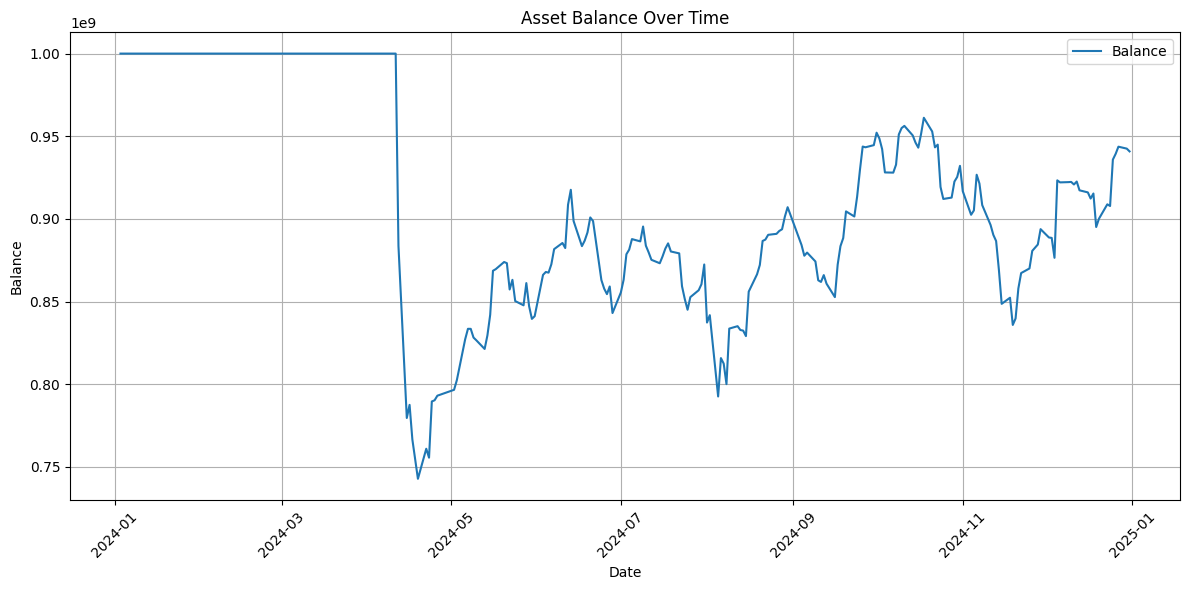

In [164]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_asset_balance(asset_df: pd.DataFrame):
    """
    Plots the 'balance' column of the given asset DataFrame using matplotlib.

    Args:
        asset_df (pd.DataFrame): DataFrame containing a 'balance' column and a 'Date' index.
    """
    if 'balance' not in asset_df.columns:
        print("Error: 'balance' column not found in the DataFrame.")
        return

    if not isinstance(asset_df.index, pd.DatetimeIndex):
        print("Error: DataFrame index is not a DatetimeIndex. Ensure 'Date' is the index.")
        return

    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    plt.plot(asset_df.index, asset_df['balance'], label='Balance')
    plt.title('Asset Balance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.legend()
    plt.grid(True)  # Add grid lines for better readability
    plt.xticks(rotation=45) #rotate x axis labels
    plt.tight_layout() #avoid labels being cut off
    plt.show()


plot_asset_balance(asset_df)

In [163]:
import mathplotlib.pyplot as plt

ModuleNotFoundError: No module named 'mathplotlib'

In [162]:
plt.figure(figsize=(14, 7))
plt.plot(asset_df['balance'], label='Portfolio Value')
plt.plot(asset_df['cash'], label='Cash')

NameError: name 'plt' is not defined

In [43]:
detail_df.to_csv('portfolio\\detail.csv')

In [44]:
asset_df.to_csv('portfolio\\asset.csv')

In [45]:
trading_log_df.to_csv('portfolio\\trading_log.csv')

# Evaluation

In [ ]:
def backtest_strategy(ts, rfrate=0.05, trading_day=252, freq="D"):
    """
    -----------------------------------------------------------------------------
    | Output: Beta CAPM metric                                                  |
    -----------------------------------------------------------------------------
    | Inputs: - ts: returns of the time series                                  |
    -----------------------------------------------------------------------------
    """
    # Database connection parameters
    db_params = {
        "host": "api.algotrade.vn",
        "port": 5432,
        "database": "algotradeDB",
        "user": "intern_read_only",
        "password": "ZmDaLzFf8pg5"
    }

    connection = psycopg2.connect(**db_params)
    ts = ts.astype(float)
    start = ts.index.min().strftime('%Y-%m-%d')
    end = ts.index.max().strftime('%Y-%m-%d')

    ######################### COMPUTE THE BETA ##################################
    # Importation of benchmark
    benchmark = pd.DataFrame(execute_query(index_query, start, end), columns=["Datetime", "Open", "Close"])
    benchmark.set_index("Datetime", inplace=True)
    benchmark = benchmark.astype(float)
    ret_bench = benchmark["Close"].pct_change().dropna()
    ret_bench = ret_bench.astype(float)

    # Concat the asset and the benchmark
    join = pd.concat((ts, ret_bench), axis=1).dropna()
    join[['Asset', 'Close']] = join[['Asset', 'Close']].astype(float)

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov / var

    ######################### COMPUTE THE ALPHA #################################
    time_length = (datetime.strptime(end, '%Y-%m-%d') - datetime.strptime(start, '%Y-%m-%d')).days / 365.25
    cum_rets = (1 + ts).cumprod()
    mean_stock_return = cum_rets.iloc[-1].item()**(1 / time_length) - 1

    # Mean of returns for the market
    cum_rets_market = (1 + ret_bench).cumprod()
    mean_market_return = cum_rets_market.iloc[-1].item()**(1 / time_length) - 1

    # Alpha
    alpha = mean_stock_return - beta * mean_market_return

    ######################### COMPUTE THE SHARPE ################################
    mean = mean_stock_return
    std = ts.std().item() * np.sqrt(trading_day)
    Sharpe = (mean - rfrate) / std

    ######################### COMPUTE THE SORTINO ###############################
    downward = ts[ts < 0]
    std_downward = downward.std().item() * np.sqrt(trading_day)
    Sortino = mean / std_downward

    ######################### COMPUTE THE DRAWDOWN ###############################
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1
    drawdown = ((cum_rets) / running_max - 1)
    min_drawdown = -drawdown.min().item()

    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    n = 100000
    t = int(n * theta)
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)), columns=["Simulations"])
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]

    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t, :].mean().values[0]

    ######################### PLOT THE RESULTS #################################
    print(f"""
    Annulized Return: {np.round(mean_stock_return*100, 2)}% \t Volatility: {np.round(std*100, 2)} %\t \
    
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)}% \t 
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)}% \t CVaR: {np.round(cVaR*100, 2)}% \t 
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t Drawdown: {np.round(min_drawdown*100, 2)}%
    -----------------------------------------------------------------------------
    """)

    # Decide chart scale based on cumulative return
    log_scale = cum_rets.max().item() > 5

    plt.figure(figsize=(15, 8))
    plt.plot(cum_rets, color="#035593", linewidth=3)
    plt.plot(cum_rets_market, color="#068C72", linewidth=3)
    if log_scale:
        plt.yscale("log")
        y_ticks = [1, 2, 5, 10]
        plt.yticks(y_ticks, labels=[str(int(tick)) for tick in y_ticks])
    plt.title("CUMULATIVE RETURN", size=15)
    plt.ylabel("Cumulative return", size=15)
    plt.xticks(size=15, fontweight="bold")
    plt.yticks(size=15, fontweight="bold")
    plt.legend(["Strategy", "Benchmark"], fontsize=15)
    plt.show()

  
    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown["Asset"]*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown["Asset"]*100, color="#930303", linewidth=1.5)
    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.show()
